# Detectando obras completas
En este notebook vamos a intentar detectar las obras musicales y agruparlas según su autor y tipo de obra.

In [1]:
%%capture
!sudo apt install tesseract-ocr

In [2]:
%%capture
!sudo apt-get install tesseract-ocr-spa

In [3]:
%%capture
pip install pytesseract

In [4]:
%%capture
pip install tesseract

In [5]:
import cv2
import sys
import pytesseract
from pytesseract import Output
import argparse
import pickle
import re,string
import random
from unicodedata import normalize
import numpy as np
from matplotlib import pyplot as plt
from statistics import mean,stdev

In [18]:
%%capture
!unzip Fotos.zip

In [6]:
with open("texto2.pickle", "rb") as f:
    texto = pickle.load(f)
with open("pentagramas2.pickle", "rb") as f:
    pentagramas2 = pickle.load(f)
with open("ini_Obras.pickle", "rb") as f:
    ini_Obras = pickle.load(f)

## Implementando las funciones

- **Detectar los pentagramas**

In [7]:
def pentagramas(foto): 
  foto2 = foto.copy()
  (H,W) = foto.shape[:2]
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  tthreshInv = cv2.resize(threshInv,(int(W*25/100),int(H*25/100)))
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      #cv2.drawContours(foto2, [c], -1, (119, 90, 17), 2)
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      cv2.rectangle(foto2, (x, y), (x + w, y + h), (119, 90, 17), 2)
  return foto2

- **Borrar pentagramas**

In [8]:
def pentagramaBlanco(foto):
  (H,W) = foto.shape[:2]
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  tthreshInv = cv2.resize(threshInv,(int(W*25/100),int(H*25/100)))
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      cv2.drawContours(foto, [c], -1, (255, 255, 255), -1)
      (x, y, w, h) = cv2.boundingRect(c)
      cv2.rectangle(foto, (x, y+40), (x + w, y + h-40), (255, 255, 255), -1)
  return foto

- **Detectar texto**

In [9]:
def espacios(str):
  n = len(str)
  return len([str[i] for i in range(0,n) if str[i]==' ']) == n

def sacarTexto(foto): # Esta función es importante ya que debemos ajustar las cosas bien para poder distinguir cada cosa correctamente.
  
  fotografia = foto.copy()
  foto2 = foto.copy()
  fotografia = pentagramaBlanco(fotografia)
  results = pytesseract.image_to_data(fotografia, lang='spa', output_type=Output.DICT)

  (H,W) = fotografia.shape[:2] # Alto y ancho de la imagen

  for i in range(0, len(results["text"])): # Vamos identificando todas las palabras

    # Sacamos las coordenadas de la palabra
	  x = results["left"][i]
	  y = results["top"][i]
	  w = results["width"][i]
	  h = results["height"][i]
	  # sacamos la palabra 
	  text = results["text"][i]
	  conf = int(results["conf"][i])


	  # Esto es para distinguir texto de otras cosas, si el área que ocupa ese objeto es pequeña entonces es una palabra.
	  if conf > 0.15 and 0 < h < 30 and 8 < w < 350 and not(espacios(text)):

		  text = "".join([c if ord(c) < 300 else "" for c in text]).strip()
		  cv2.rectangle(foto2, (x, y), (x + w, y + h), (0, 255, 0), 2) # Rodeamos la palabra
		  cv2.putText(foto2, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.4, (0, 0, 255), 3) # Ponemos arriba la palabra en formato texto.

  return foto2

- **Guardar el texto**

In [10]:
def remove_punctuation(frase):
  char = re.sub('[%s]' % re.escape(string.punctuation.replace('-','')),'',frase)
  char = char.replace('¿','').replace('?','').replace('`','').replace('´','').replace('#','').lower()
  char = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", char), 0, re.I
    )
  char = normalize( 'NFC', char)
  return char


def guardarTexto(texto,foto,pag): # "texto" es un diccionario, le pasamos una "foto" para que almacene el texto de la página "pag"
  foto = pentagramaBlanco(foto)
  results = pytesseract.image_to_data(foto, lang='spa', output_type=Output.DICT)
  dic = {'text' : [], 'left' : [], 'top' : [], 'width' : [], 'height' : []}
  n = len(results['text'])
  for i in range(0,n):
    x = results['left'][i]
    y = results['top'][i]
    h = results['height'][i]
    w = results['width'][i]
    text = results['text'][i]
    conf = int(results['conf'][i])
    if conf > 0.15 and 0 < h < 30 and 8 < w < 350 and not(espacios(remove_punctuation(text))):
      dic['text'].append(remove_punctuation(text))
      dic['left'].append(x)
      dic['top'].append(y)
      dic['height'].append(h)
      dic['width'].append(w)
  texto[pag] = dic

- **Guardar los pentagramas**

In [11]:
def guardarPentagramas(pentagramas,foto,pag): 
  (H,W) = foto.shape[:2]
  P = []
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  tthreshInv = cv2.resize(threshInv,(int(W*25/100),int(H*25/100)))
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      P.append(cv2.boundingRect(c))
  pentagramas[pag] = P

In [140]:
def borrarTexto(foto,numPag):
  n = len(texto[numPag]['text'])
  foto2 = foto.copy()
  for i in range(0,n):
    x = texto[numPag]['left'][i]
    y = texto[numPag]['top'][i]
    h = texto[numPag]['height'][i]
    w = texto[numPag]['width'][i]
    cv2.rectangle(foto2, (x-150, y-2), (x + w + 150, y + h+2), (255, 255, 255), -1)
  return foto2

In [13]:
def esNumero(cadena):
  try:
    int(cadena)
    return True
  except:
    return False

## Proceso de creación de las bounding-box de las obras
- Aquí tenemos un pequeño problema. Algunas obras empiezan en una página y terminan en la siguiente. Esto va a haber que tenerlo en cuenta

- Mostramos la zona de interés de una foto aleatoria

In [14]:
claves = [cla for cla in texto]

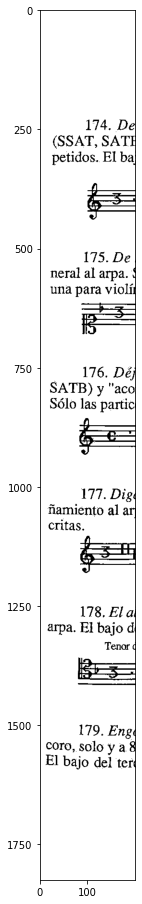

In [ ]:
cla = random.choice(claves)
pag = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
pag = cv2.cvtColor(pag,cv2.COLOR_BGR2GRAY)
_,pag=cv2.threshold(pag,230,255,cv2.THRESH_BINARY)
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(255-pag[:,100:300],cmap=plt.cm.binary)
plt.show()

- Guardamos la ubicación del **principio** de todas nuestras obras

1
2
3
4


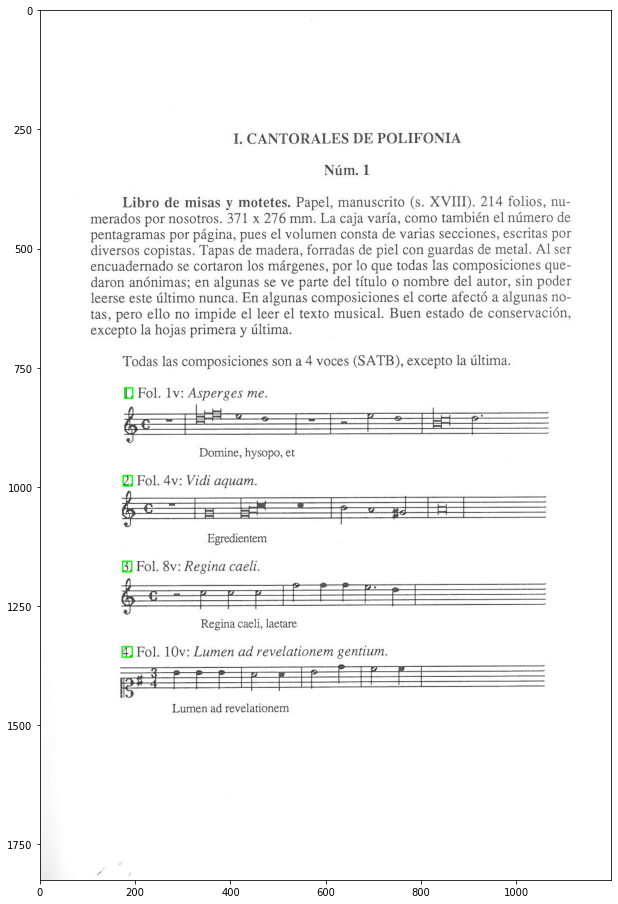

5
6
7


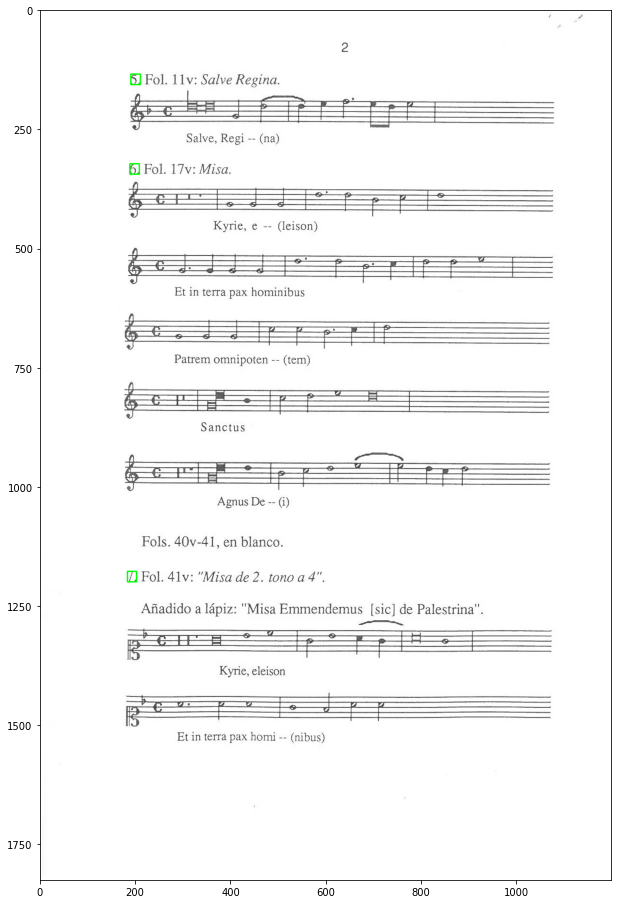

8


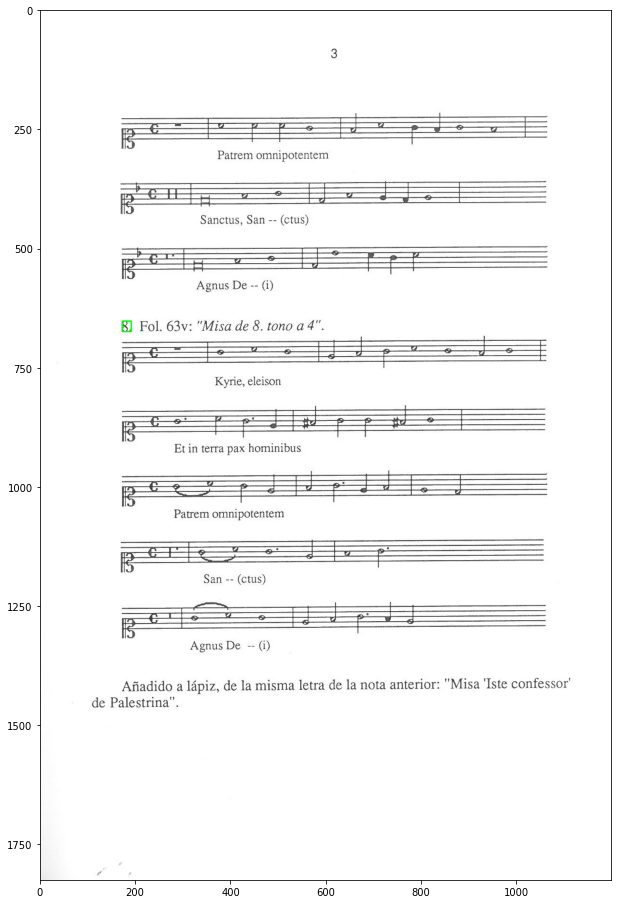

9
10


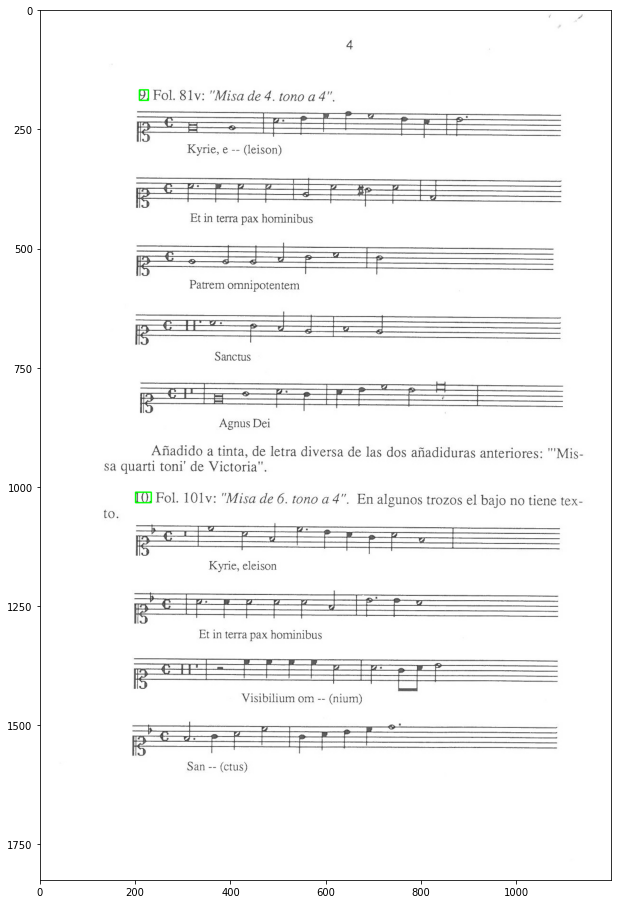

11
12


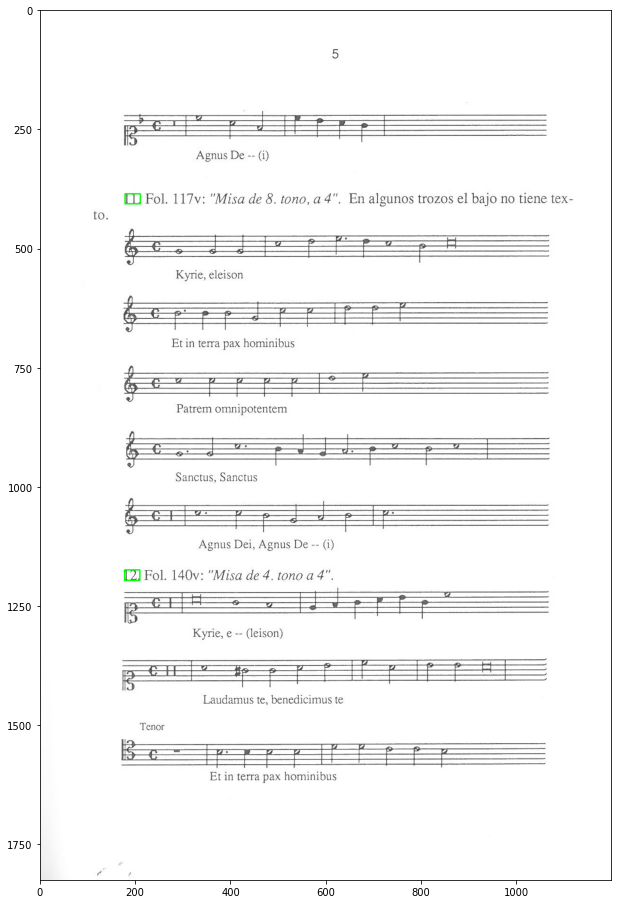

13
14


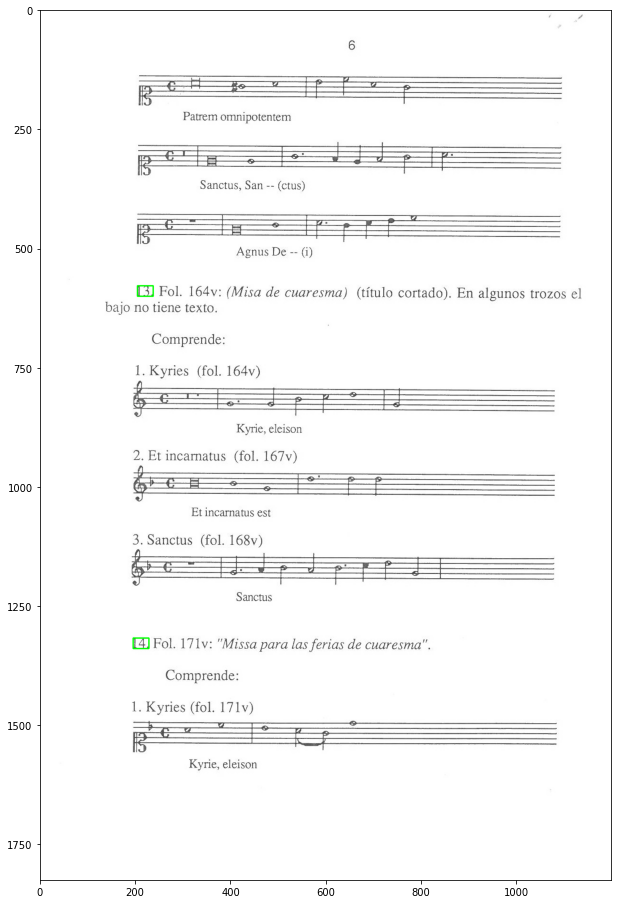

15
16
17


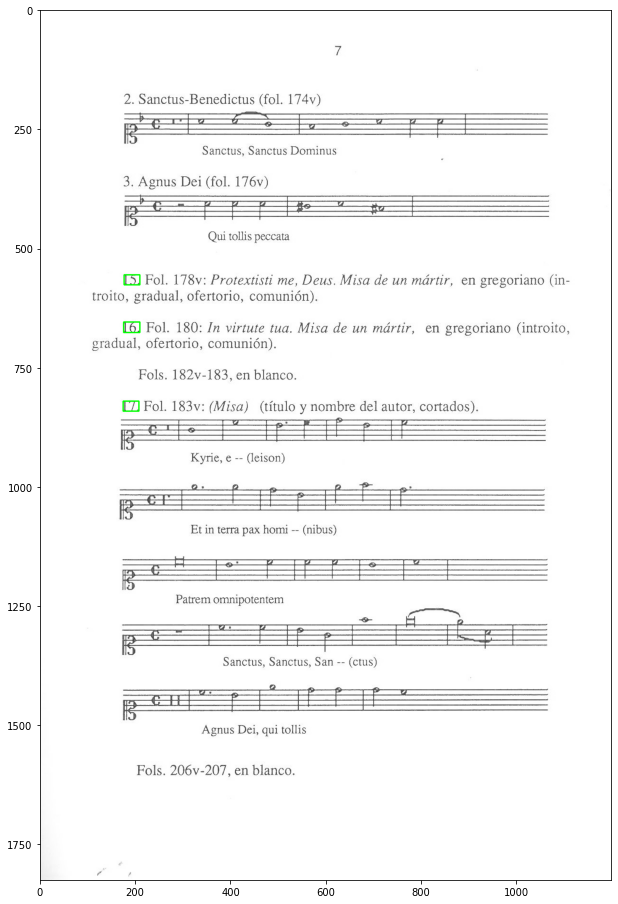

18
19
20
21
22


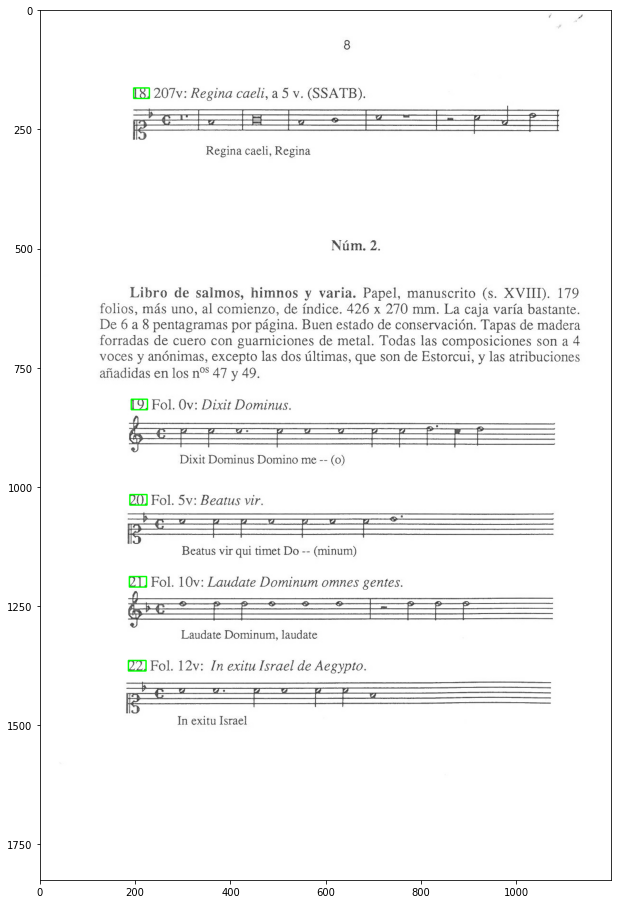

23
24
25
26
27
28


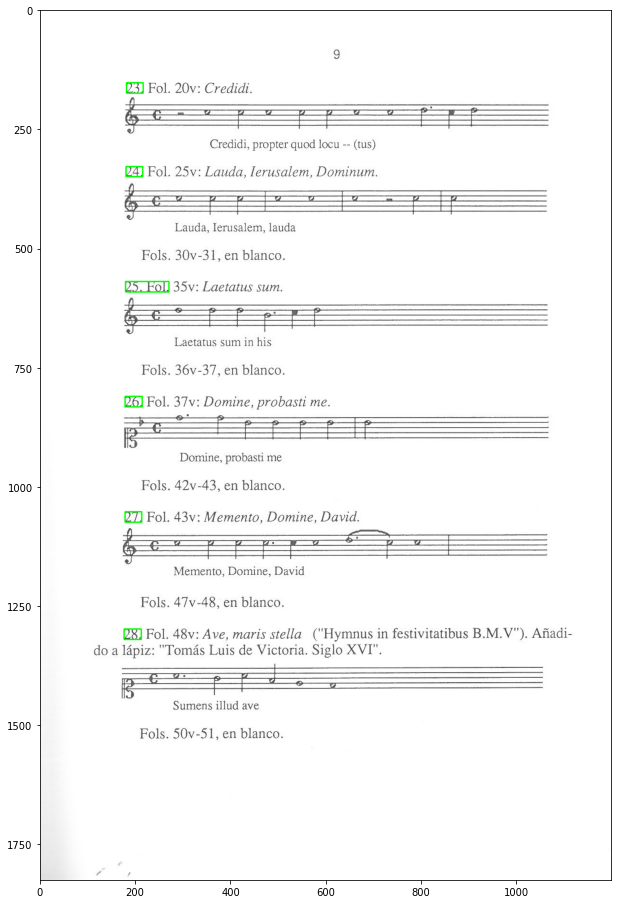

29
30
31
32
33
34
35


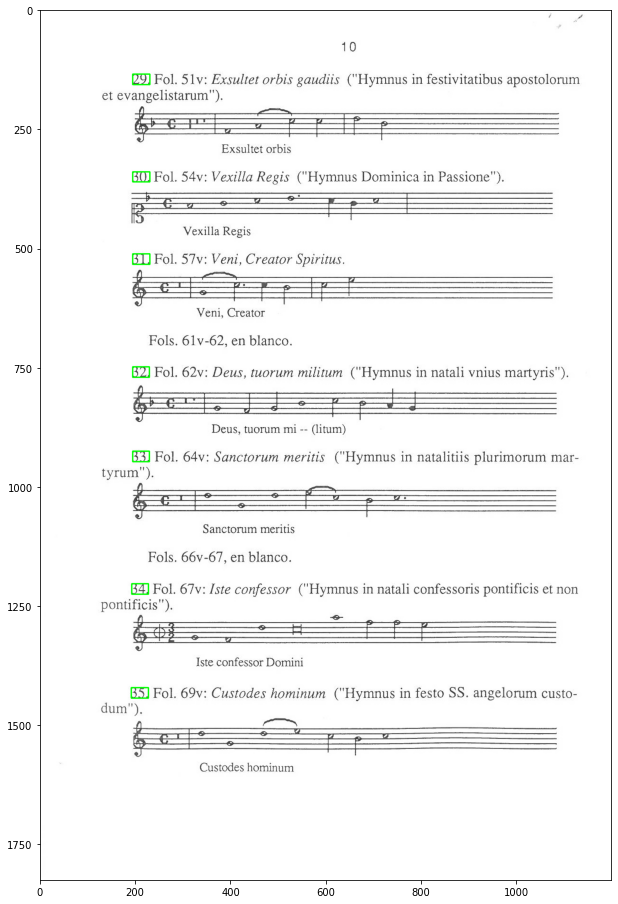

In [ ]:
c = iter(claves)
#ini_Obras = {}
Obs = list(range(1,1554)) # hay 1553 obras
k = 0
for i in range(0,10): # 377 = len(claves)
  cla = next(c)
  #ini_Obras[cla] = {}
  pag = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
  pag = cv2.cvtColor(pag,cv2.COLOR_BGR2RGB)
  n = len(texto[cla]['text'])
  for j in range(0,n):
    x = texto[cla]["left"][j]
    y = texto[cla]["top"][j]
    w = texto[cla]["width"][j]
    h = texto[cla]["height"][j]
    text = texto[cla]["text"][j]
    if 130 < x < 300 and esNumero(text) and int(text) == Obs[k]:
      k = k + 1
      print(text)
      #ini_Obras[cla][k] = x,y
      cv2.rectangle(pag, (x, y), (x + w, y + h), (0, 255, 0), 2)
  fig, ax = plt.subplots(1,1,figsize=(16,16))
  ax.imshow(pag)
  plt.show()

In [ ]:
with open("ini_Obras.pickle", "wb") as f:
    pickle.dump(ini_Obras, f)

In [ ]:
print([cla for cla in ini_Obras])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226, 

In [ ]:
print(ini_Obras[383])

{1549: (186, 332), 1550: (183, 580), 1551: (182, 852), 1552: (181, 1166), 1553: (181, 1373)}


- Probamos con la última página a ver que tal lo hace

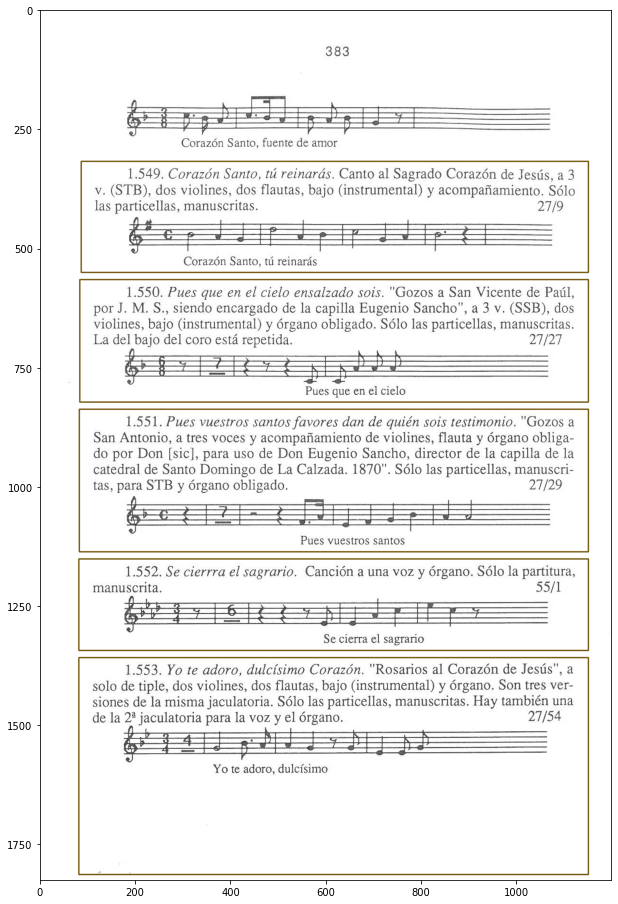

In [ ]:
pag = cv2.imread('Fotos/pag383.jpg')
pag = cv2.cvtColor(pag,cv2.COLOR_BGR2RGB)
n = len(ini_Obras[383])
obras = [cla for cla in ini_Obras[383]]
for i in range(0,n):
  if i < n-1:
    x1,y1 = ini_Obras[383][obras[i]]
    x2,y2 = ini_Obras[383][obras[i+1]]
    cv2.rectangle(pag, (x1-100, y1-15), (1150, y2-30), (119, 90, 17), 2)
  if i == n-1:
    x,y = ini_Obras[383][obras[i]]
    cv2.rectangle(pag, (x-100, y-15), (1150,y+440), (119, 90, 17), 2)
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(pag)
plt.show()

- Elegimos páginas de forma aleatoria para ver que tal lo hace

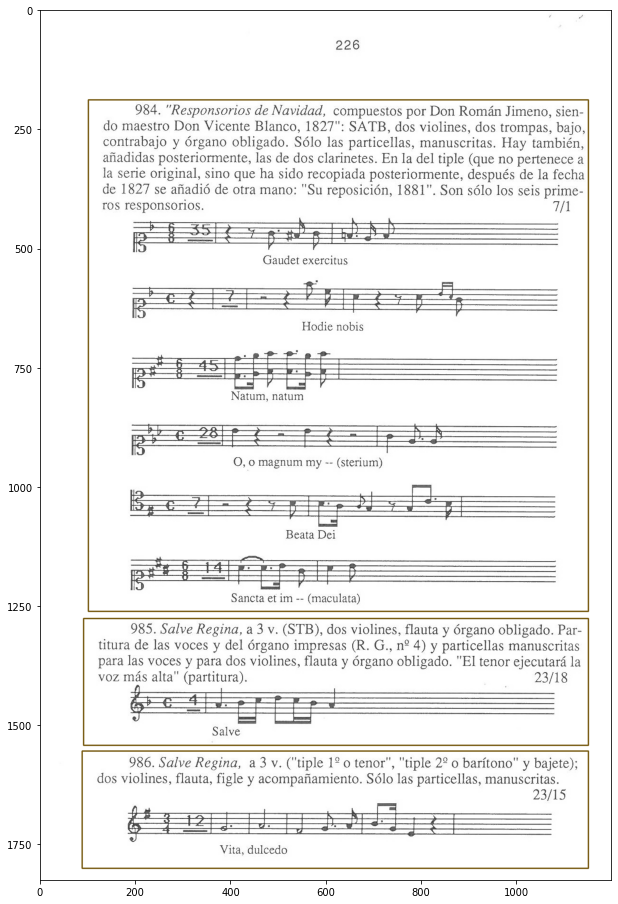

In [ ]:
cla = random.choice(claves)
pag = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
pag = cv2.cvtColor(pag,cv2.COLOR_BGR2RGB)
n = len(ini_Obras[cla])
obras = [cla for cla in ini_Obras[cla]]
for i in range(0,n):
  if i < n-1:
    x1,y1 = ini_Obras[cla][obras[i]]
    x2,y2 = ini_Obras[cla][obras[i+1]]
    cv2.rectangle(pag, (x1-100, y1-10), (1150, y2-25), (119, 90, 17), 2)
  if i == n-1:
    x,y = ini_Obras[cla][obras[i]]
    cv2.rectangle(pag, (x-100, y-13), (1150,1800), (119, 90, 17), 2)
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(pag)
plt.show()

## Más cosas. Intentando perfeccionar un poquillo más
Vamos a investigar los kernel de OpenCV

In [24]:
tipos = ['Misa','Salmo','Villancico','Magnificat','Lamentación','Himno','Rosario','Responsorio','Otro']

In [25]:
capitulos = {1:list(range(1,24)),2:list(range(25,35)),3:list(range(35,56)),4:list(range(57,69)),5:list(range(69,77)),6:list(range(77,103)),7:list(range(103,112)),8:list(range(113,142)),9:list(range(143,153)),10:list(range(153,181)),11:list(range(181,205)),12:list(range(205,222)),13:list(range(223,247)),14:list(range(247,337)),15:list(range(337,346)),16:list(range(347,384))}

In [ ]:
def bloques(foto,img):
  results = pytesseract.image_to_data(img, output_type=Output.DICT)
  L=[[[],[],[],[]] for i in range (0,len(set(results['block_num'])))]
  for i in range (0, len(results['block_num'])):
    if results['text'][i]!='' and results['text'][i]!=' ':
      j= results['block_num'][i]-1
      L[j][0].append(results['left'][i])
      L[j][1].append(results['top'][i])
      L[j][2].append(results['width'][i])
      L[j][3].append(results['height'][i])
  i=0
  for lista in L:
    if lista!=[[],[],[],[]]:
      x=lista[0][0]-10
      y=lista[1][0]-10
      z1=max(lista[0])
      z=z1+ lista[2][lista[0].index(z1)]+10
      w1=max(lista[1])
      w=w1+ lista[3][lista[1].index(w1)]+3
      cv2.rectangle(foto, (x, y), (z,w), (0, 0, 255), 2)
      cv2.putText(foto, f'bloque {i}', (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    i=i+1

In [ ]:
cla = random.choice(claves)

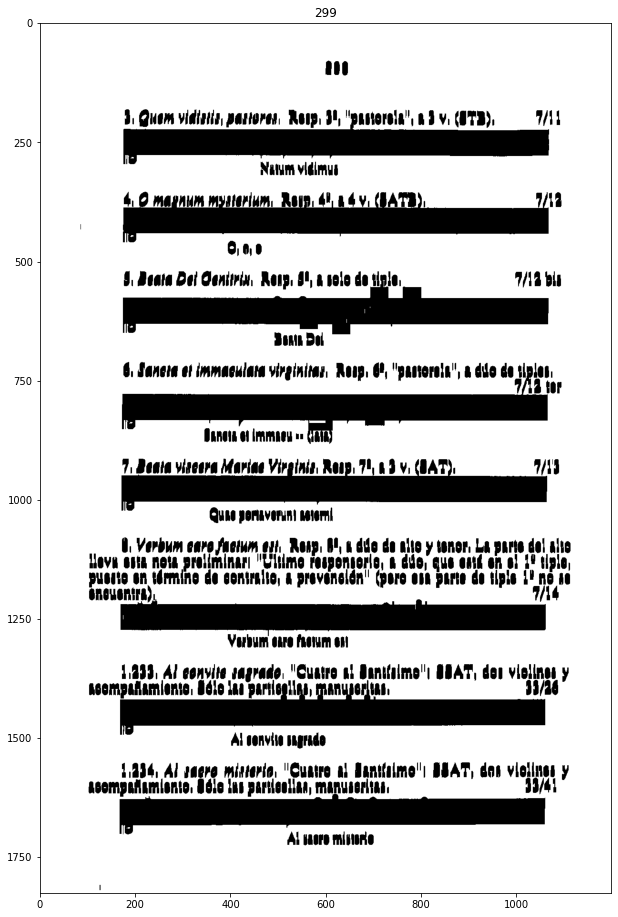

In [ ]:
foto = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
foto = cv2.cvtColor(foto,cv2.COLOR_BGR2RGB)
pag = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
pag = cv2.cvtColor(pag,cv2.COLOR_BGR2GRAY)
T,pag = cv2.threshold(pag, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
for i in range(0,10):
  pag = cv2.dilate(pag,(15,15))
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(pag,cmap=plt.cm.binary)
ax.set_title(str(cla))
plt.show()

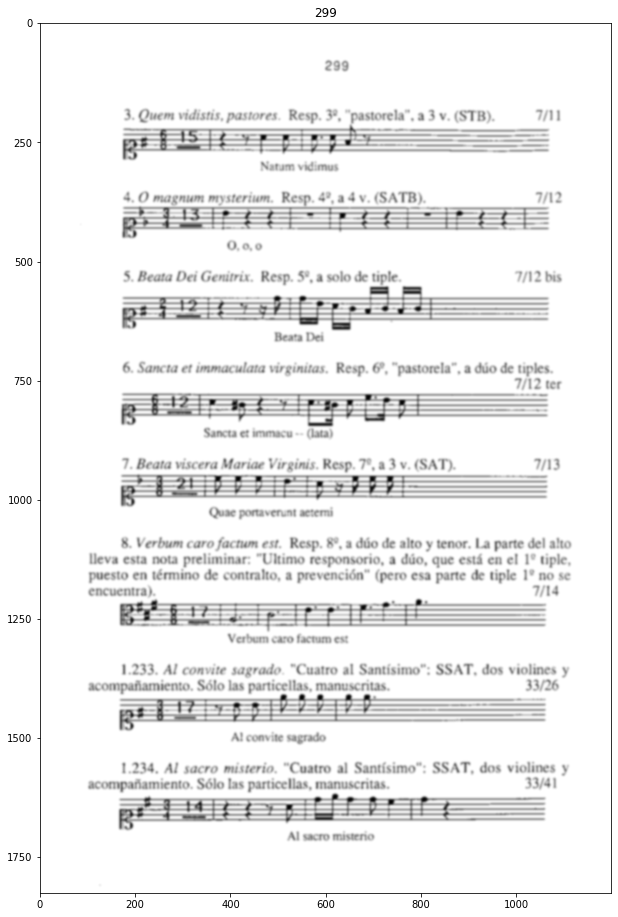

In [ ]:
foto = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
foto = cv2.cvtColor(foto,cv2.COLOR_BGR2RGB)
pag = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
pag = cv2.cvtColor(pag,cv2.COLOR_BGR2GRAY)
T,pag = cv2.threshold(pag, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
for i in range(0,10):
  pag = cv2.GaussianBlur(pag, (3,3), 0)
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(pag,cmap=plt.cm.binary)
ax.set_title(str(cla))
plt.show()

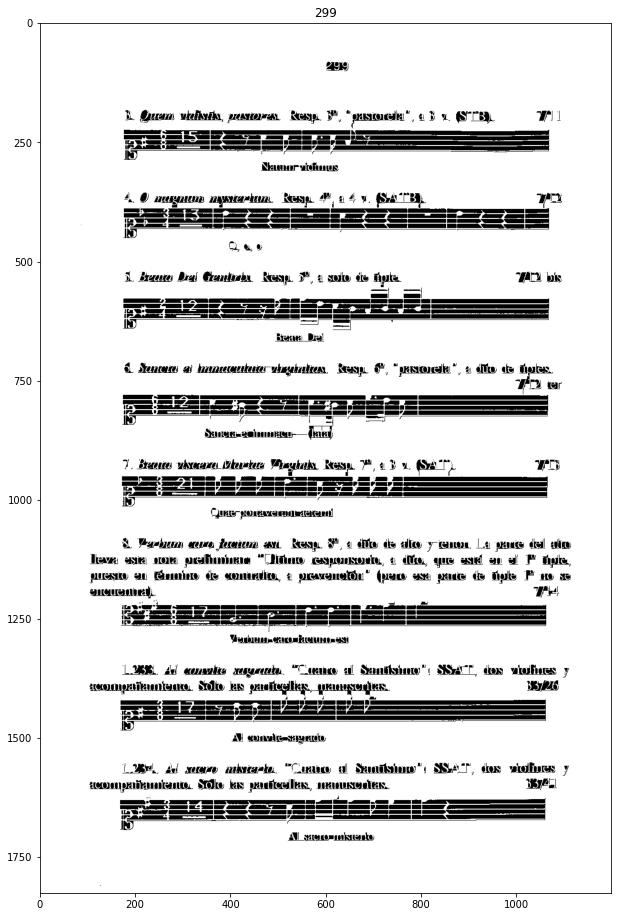

In [ ]:
foto = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
foto = cv2.cvtColor(foto,cv2.COLOR_BGR2RGB)
pag = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
pag = cv2.cvtColor(pag,cv2.COLOR_BGR2GRAY)
T,pag = cv2.threshold(pag, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
sqKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))
for i in range(0,1):
  pag = cv2.morphologyEx(pag,cv2.MORPH_BLACKHAT,sqKernel)
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(pag,cmap=plt.cm.binary)
ax.set_title(str(cla))
plt.show()

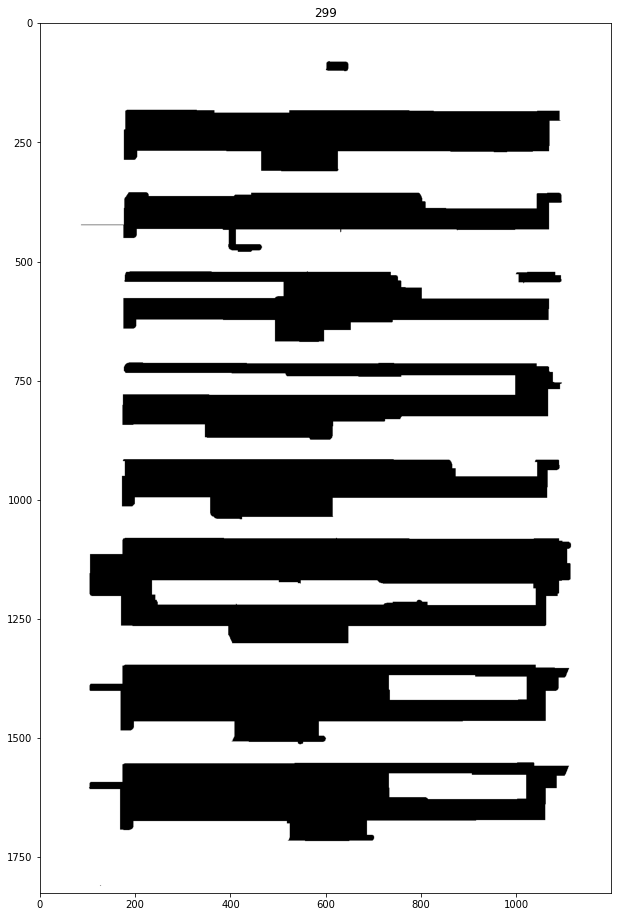

In [ ]:
foto = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
foto = cv2.cvtColor(foto,cv2.COLOR_BGR2RGB)
pag = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
pag = cv2.cvtColor(pag,cv2.COLOR_BGR2GRAY)
T,pag = cv2.threshold(pag, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(150,30))
pag=cv2.morphologyEx(pag,cv2.MORPH_CLOSE,rectKernel)
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(pag,cmap=plt.cm.binary)
ax.set_title(str(cla))
plt.show()

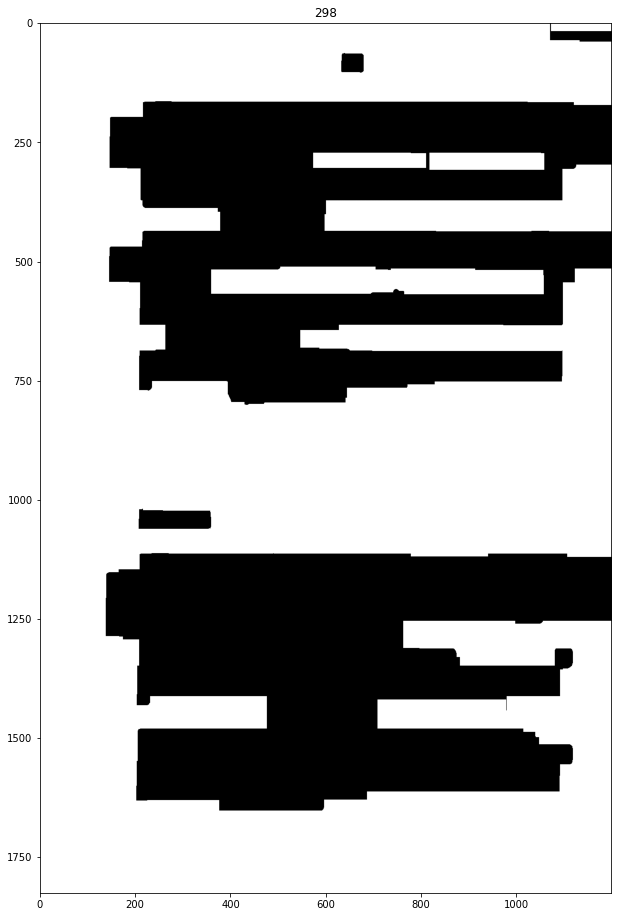

In [ ]:
foto = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
foto = cv2.cvtColor(foto,cv2.COLOR_BGR2RGB)
pag = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
pag = cv2.cvtColor(pag,cv2.COLOR_BGR2GRAY)
T,pag = cv2.threshold(pag, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
for i in range(0,20):
  pag = cv2.dilate(pag,(15,15))
rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(150,30))
pag=cv2.morphologyEx(pag,cv2.MORPH_CLOSE,rectKernel)
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(pag,cmap=plt.cm.binary)
ax.set_title(str(cla))
plt.show()

In [20]:
def verPagina(num_obra):
  for cla in ini_Obras:
    if num_obra in ini_Obras[cla]: return cla

In [316]:
def mostrarObra(num_obra):

  num_pag = verPagina(num_obra)
  ultimo = [ob for ob in ini_Obras[num_pag]][-1]
  if num_obra != ultimo:
    foto = cv2.imread('Fotos/pag'+str(num_pag)+'.jpg')
    foto = cv2.cvtColor(foto,cv2.COLOR_BGR2RGB)
    pag = borrarTexto(foto.copy(),num_pag)
    pag = cv2.cvtColor(pag,cv2.COLOR_RGB2GRAY)
    T,pag = cv2.threshold(pag, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    for i in range(0,60):
      pag = cv2.dilate(pag,(15,15))
    rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(150,30))
    pag=cv2.morphologyEx(pag,cv2.MORPH_CLOSE,rectKernel)
    cnts,_ = cv2.findContours(pag, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    y1 = ini_Obras[num_pag][num_obra][1]
    y2 = ini_Obras[num_pag][num_obra+1][1]
    for c in cnts[::-1]:
      y,h = cv2.boundingRect(c)[1],cv2.boundingRect(c)[3]
      if cv2.contourArea(c) >= 15000 and y1 < y < y2:
       # Mejor sacar el rectángulo contenido
        fig, ax = plt.subplots(1,1,figsize=(16,16))
        ax.imshow(foto[y1-15:min(y+h,y2)-15,70:1500])
        plt.show()
        break
  else:
    foto = cv2.imread('Fotos/pag'+str(num_pag)+'.jpg')
    foto = cv2.cvtColor(foto,cv2.COLOR_BGR2RGB)
    foto2 = cv2.imread('Fotos/pag'+str(verPagina(num_obra+1))+'.jpg')
    foto2 = cv2.cvtColor(foto2,cv2.COLOR_BGR2RGB)
    pag = borrarTexto(foto.copy(),num_pag)
    pag2 = borrarTexto(foto2.copy(),num_pag)
    pag = cv2.cvtColor(pag,cv2.COLOR_RGB2GRAY)
    pag2 = cv2.cvtColor(pag2,cv2.COLOR_RGB2GRAY)
    T,pag = cv2.threshold(pag, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    T,pag2 = cv2.threshold(pag2, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    for i in range(0,60):
      pag = cv2.dilate(pag,(15,15))
      pag2 = cv2.dilate(pag2,(15,15))
    rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(150,30))
    pag=cv2.morphologyEx(pag,cv2.MORPH_CLOSE,rectKernel)
    pag2=cv2.morphologyEx(pag2,cv2.MORPH_CLOSE,rectKernel)
    cnts,_ = cv2.findContours(pag, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts2,_ = cv2.findContours(pag2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    y1 = ini_Obras[num_pag][num_obra][1]
    y2 = ini_Obras[verPagina(num_obra+1)][num_obra+1][1]
    for c in cnts[::-1]:
      y,h = cv2.boundingRect(c)[1],cv2.boundingRect(c)[3]
      if cv2.contourArea(c) >= 15000 and y1 < y+h:
        foto = foto[y1-15:y+h-15,70:1500]
        break
    if foto.shape == (1825, 1200, 3):
      foto = foto[y1-15:1800,70:1500]
    for c in cnts2[::-1]:
      y,h = cv2.boundingRect(c)[1],cv2.boundingRect(c)[3]
      if cv2.contourArea(c) >= 15000 and y < y2:
        foto2 = foto2[150:min(y+h,y2)-15,70:1500]
        break
    fig, ax = plt.subplots(1,1,figsize=(16,16))
    ax.imshow(np.concatenate([foto,foto2],axis=0))
    plt.show()

In [318]:
mostrarObra(1375)